<a href="https://colab.research.google.com/github/jdelat09/Awesome-Coding-Interview-Question-Patterns/blob/master/JON_Copy_of_knn_487lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# k-Nearest Neighbor (kNN) exercise


The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated

In this exercise you will implement these steps and understand the basic Image Classification pipeline, cross-validation, and gain proficiency in writing efficient, vectorized code.

In [95]:
# Run some setup code for this notebook.

import random
import numpy as np
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [96]:
# Load the raw CIFAR-10 data.
import tensorflow as tf
print(tf.__version__)
"""
X_train: 50,000 images (32 X 32 X 3)
y_train : 50,000 labels 2D aray 
X_test : 10,000 images (32 X 32 X 2)
y_test : 10,000 labels 2D Array

"""

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
assert X_train.shape == (50000, 32, 32, 3)
assert X_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)

2.7.0


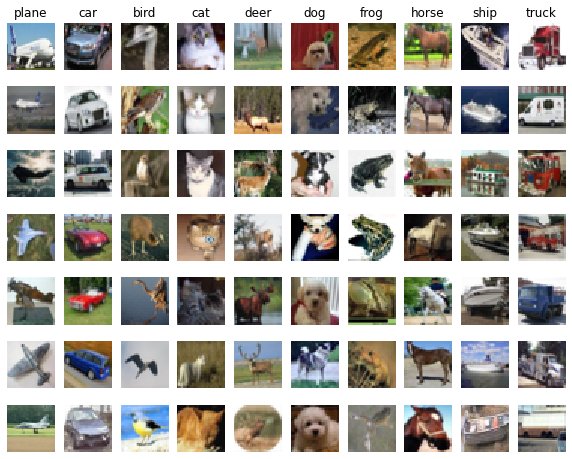

In [97]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [98]:
# Subsample the data for more efficient code execution in this exercise

#We splice and get first 5,000 by using mask below
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]


num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
#print(X_train.shape, X_test.shape)
#print(X_train)

In [99]:
# TODO Create a kNN classifier . 
# Remember that training a kNN classifier is a noop: 
# the Classifier simply remembers the data and does no further processing 
from builtins import range
from builtins import object
import numpy as np
from past.builtins import xrange


class KNearestNeighbor(object):
    """ a kNN classifier with L2 distance """

    def __init__(self):
        pass

    def train(self, X, y):
        """
        Train the classifier. For k-nearest neighbors this is just
        memorizing the training data.

        Inputs:
        - X: A numpy array of shape (num_train, D) containing the training data
          consisting of num_train samples each of dimension D.
        - y: A numpy array of shape (N,) containing the training labels, where
             y[i] is the label for X[i].
        """
        self.X_train = X
        self.y_train = y


    def compute_distances_two_loops(self, X):
        """
        Compute the distance between each test point in X and each training point
        in self.X_train using a nested loop over both the training data and the
        test data.

        Inputs:
        - X: A numpy array of shape (num_test, D) containing test data.

        Returns:
        - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
          is the Euclidean distance between the ith test point and the jth training
          point.
        """
        num_test = X.shape[0]
        #print("num_test", num_test)
        num_train = self.X_train.shape[0]
        #print("num _ train", num_train)
        dists = np.zeros((num_test, num_train))

        for i in range(num_test):
            for j in range(num_train):
                dists[i, j] = np.sqrt(np.sum((X[i].astype(np.int64) - self.X_train[j].astype(np.int64))**2))
                pass
        return dists

    def compute_distances_one_loop(self, X):
        """
        Compute the distance between each test point in X and each training point
        in self.X_train using a single loop over the test data.

        Input / Output: Same as compute_distances_two_loops
        """
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        """np.zeros(rows, columns) 500X5000 500 rows and 5,000 columns"""
        dists = np.zeros((num_test, num_train))
        #print(dists)
        #print(dists.shape)
        for i in range(num_test):
            dists[i] = np.sqrt(np.sum((X[i].astype(np.int64) - self.X_train.astype(np.int64))**2, axis=1))
            pass
        return dists

    def compute_distances_no_loops(self, X):
        """
        Compute the distance between each test point in X and each training point
        in self.X_train using no explicit loops.

        Input / Output: Same as compute_distances_two_loops
        probably has rounding error here also but this one is an approx to euclidian and can be done better with library call
        dist = np.linalg.norm(point1 - point2)
        """
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train))
        #dists = np.sqrt((X**2).sum(axis=1, keepdims=True) + (self.X_train**2).sum(axis=1) - 2 * X.dot(self.X_train.T))
        pass
        return dists

    def predict_labels(self, dists, k=1):
        """
        Given a matrix of distances between test points and training points,
        predict a label for each test point.

        Inputs:
        - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
          gives the distance betwen the ith test point and the jth training point.

        Returns:
        - y: A numpy array of shape (num_test,) containing predicted labels for the
          test data, where y[i] is the predicted label for the test point X[i].
        """
        num_test = dists.shape[0]
        y_pred = np.zeros(num_test)
        for i in range(num_test):
            # A list of length k storing the labels of the k nearest neighbors to
            # the ith test point.
            closest_y = []
            #print("all points", self.y_train[np.argsort(dists[i])])
            closest_y = self.y_train[np.argsort(dists[i])][:k]
            #print("Closest y", closest_y)
            pass
            closest_y=np.ndarray.flatten(closest_y)
            y_pred[i] = np.argmax(np.bincount(closest_y))
            pass

        #print(y_pred)
        return y_pred
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps: 

1. First we must compute the distances between all test examples and all train examples. 
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and test examples. For example, if there are **Ntr** training examples and **Nte** test examples, this stage should result in a **Nte x Ntr** matrix where each element (i,j) is the distance between the i-th test and j-th train example.



In [100]:

# Test your implementation:
dists = classifier.compute_distances_one_loop(X_test)


In [105]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=1)
#print("Y_TEST PRED", y_test_pred, y_test_pred.shape)
y_test=y_test.flatten()
#print(y_test)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


Now lets try out a larger `k`, say `k = 5`:

In [73]:
y_test_pred = classifier.predict_labels(dists, k=5)
y_test=y_test.flatten()
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 139 / 500 correct => accuracy: 0.278000


You should expect to see a slightly better performance than with `k = 1`.

### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

In [94]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
################################################################################
# TODO:                                                                        #
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
# Hint: Look up the numpy array_split function.                                #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

X_train_folds = np.array_split(X_train, num_folds)
y_train_folds = np.array_split(y_train, num_folds)


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}
for key in k_choices:
  k_to_accuracies[key] = []


################################################################################
# TODO:                                                                        #
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                               #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
""""Since we splitted our training data(size 5000) into 5 parts with only using 1 part
as test/validation data we tested 1000 thus amount tested = 1000"""
amount_tested = 500
for k_choice in k_choices:
  for model in range(num_folds):
    
    #get test data and test labels by indexing into folds 
    test_data = X_train_folds[model]
    test_labels = y_train_folds[model]
    
    ranges = range(num_folds)
    #indices to concatenate that dont include test data
    train_indices = [x for i, x in enumerate(ranges) if i!= model]
    #below returns 2D array of everything that isnt test of length size 4
    train_args = [X_train_folds[x] for x in train_indices]
    train_label_args = [y_train_folds[x] for x in train_indices]
    
    #get train data and labels by concatenating anything that is not part
    #of test data
    train_data = np.concatenate(train_args)
    train_labels = np.concatenate(train_label_args)
    
    #start of training,calculating distances, and predicting
    classifier.train(train_data, train_labels)
    dists = classifier.compute_distances_no_loops(test_data)

    y_test_pred = classifier.predict_labels(dists, k=k_choice)
    test_labels = test_labels.flatten()
    num_correct = np.sum(y_test_pred == test_labels)
    accuracy = float(num_correct) / amount_tested
    k_to_accuracies[k_choice].append(accuracy)
    print('Got %d / %d correct => accuracy: %f' % (num_correct, amount_tested, accuracy))



    
      
print("DICT")
print(k_to_accuracies)
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

Got 103 / 500 correct => accuracy: 0.206000
Got 100 / 500 correct => accuracy: 0.200000
Got 105 / 500 correct => accuracy: 0.210000
Got 102 / 500 correct => accuracy: 0.204000
Got 105 / 500 correct => accuracy: 0.210000
Got 103 / 500 correct => accuracy: 0.206000
Got 79 / 500 correct => accuracy: 0.158000
Got 96 / 500 correct => accuracy: 0.192000
Got 97 / 500 correct => accuracy: 0.194000
Got 109 / 500 correct => accuracy: 0.218000
Got 112 / 500 correct => accuracy: 0.224000
Got 79 / 500 correct => accuracy: 0.158000
Got 96 / 500 correct => accuracy: 0.192000
Got 97 / 500 correct => accuracy: 0.194000
Got 109 / 500 correct => accuracy: 0.218000
Got 112 / 500 correct => accuracy: 0.224000
Got 79 / 500 correct => accuracy: 0.158000
Got 96 / 500 correct => accuracy: 0.192000
Got 97 / 500 correct => accuracy: 0.194000
Got 109 / 500 correct => accuracy: 0.218000
Got 103 / 500 correct => accuracy: 0.206000
Got 79 / 500 correct => accuracy: 0.158000
Got 96 / 500 correct => accuracy: 0.192000

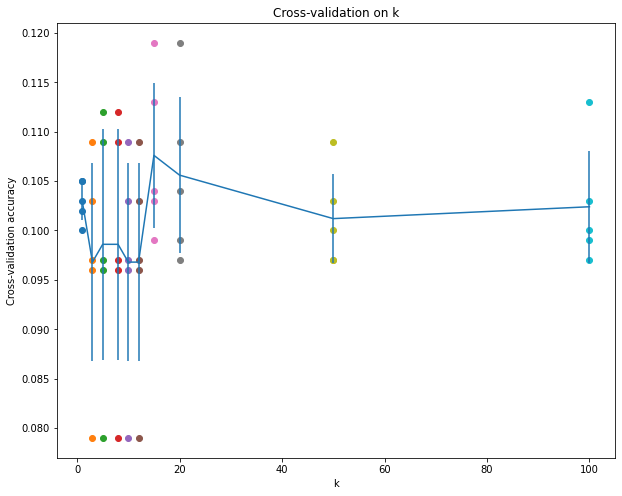

In [82]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [93]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
best_k = 1

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
dists = classifier.compute_distances_no_loops(X_test)
y_test_pred = classifier.predict_labels(dists, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 54 / 500 correct => accuracy: 0.108000
